# Assignment 4
by: _Kevin Adrián Rodríguez Ruiz_ , _Valentina Cobo Paz_, _Juan Sebastián Corredor_

email: karodriguezr@unal.edu.co, vcobop@unal.edu.co, jucorredorr@unal.edu.co

The next functions are intended to hel in common utilites

In [0]:
import urllib.request
import os
import numpy as np
from sklearn import metrics
import h5py
import matplotlib.pyplot as plt
import random
import pandas as pd
import json
from glob import glob
from glob import iglob
import re
from collections import Counter
from skimage.transform import resize

%matplotlib inline

In [0]:
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.applications import mobilenet
from keras.layers import Dense, Input, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.layers.wrappers import TimeDistributed
from keras.optimizers import RMSprop
from keras import applications
from keras.applications.mobilenet import preprocess_input, decode_predictions


original_dataset_path = "drive/My Drive/ml-datasets/multimodal_imdb.hdf5"

In [0]:
#Execute this cell to install your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Downloading dataset
metadata_path = "drive/My Drive/ml-datasets/metadata.npy"
if not os.path.isfile(metadata_path) :
  urllib.request.urlretrieve("http://lisi1.unal.edu.co/mmimdb/metadata.npy", "drive/My Drive/ml-datasets/metadata.npy")
if not os.path.isfile(original_dataset_path) :
  urllib.request.urlretrieve("http://lisi1.unal.edu.co/mmimdb/multimodal_imdb.hdf5", original_dataset_path)

In [0]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   41G  300G  12% /
tmpfs           6.4G     0  6.4G   0% /dev
tmpfs           6.4G     0  6.4G   0% /sys/fs/cgroup
tmpfs           6.4G   12K  6.4G   1% /var/colab
/dev/sda1       365G   44G  322G  12% /opt/bin
shm             6.0G  4.0K  6.0G   1% /dev/shm
tmpfs           6.4G     0  6.4G   0% /sys/firmware
drive           359G   57G  302G  16% /content/drive


# Point 1. Hang man

Design a function able to find the missing characters from a word. The function must work as follows:

```
>>> hangman("pe_p_e")
'people'

>>> hangman("phi__sop_y")
'philosophy'

>>> hangman("si_nif_c_nc_")
'significance'

>>> hangman("kn__l_d_e")
'knowledge'

>>> hangman("inte_r_ga_i_n")
'interrogation'
```

The function must be able to deal with up to 4 unknowns in arbitrary length words. The function must work in a reasonable time (max 30 seconds in a laptop).

# Dowload and arrange the dataset to work with

for this task we used the words from Princeton University to train our model

In [56]:
path=os.getcwd()
try:
    get_file("tmp",origin="http://wordnetcode.princeton.edu/wn3.1.dict.tar.gz",extract=True,cache_dir=path)
    os.remove("./datasets/tmp")
except:
    if "tmp" in os.listdir("./datasets"):
        os.remove("./datasets/tmp")
    print("Is already downloaded")

16359424/16358468 [==============================] - 0s 0us/step


In [0]:
word_list = []
input_files = ['./datasets/dict/data.adj','./datasets/dict/data.adv','./datasets/dict/data.noun','./datasets/dict/data.verb']

for filename in input_files:
    with open(filename, 'r') as f:
        # skip the header lines
        for i in range(29):
            f.readline()

        for line in f:
            word = line.split(' ')[4]
            if word.isalpha():
                word_list.append(word.lower())
new_words=[i for i in word_list if len(i)>=2]
new_words_sorted_len = len(sorted(set(new_words)))
new_words_uniq = list(set(new_words))
new_words = np.copy(new_words_uniq)
def shuffle_word(word,num=2):
    len_word=len(word)
    if len_word<=num:
        return None
    else:
        posibilities=np.array([])
        for test in range(13):
            positions=np.random.choice(range(len_word),size=num,replace=False)
            char_list_words=np.array(list(word))
            for i in positions:
                char_list_words[i]="_"
            result = "".join(char_list_words)
            posibilities=np.append(posibilities,result)
        #dict_result[word]=np.unique(posibilities)
        posibilities=np.unique(posibilities)
        result=np.vstack((posibilities,np.array([word]*len(posibilities))))
        return result

In [58]:
shuffle_words=np.array([])
for i in range(1,5):
    shuffle=pd.Series(new_words).apply(shuffle_word,num=i).dropna()
    shuffle_words=np.append(shuffle_words,shuffle)
    print("{} empty spots".format(i))

1 empty spots
2 empty spots
3 empty spots
4 empty spots


In [59]:
words_input=[]
words_target=[]
aux=1
for i in range(len(shuffle_words)):
    for j in range(len(shuffle_words[i][0])): # both have the same size
        words_input.append(shuffle_words[i][0][j])
        words_target.append(shuffle_words[i][1][j])
words_input=np.array(words_input)
words_target=np.array(words_target)
print(len(words_input),len(words_target))

2136701 2136701


In [0]:
d={"input":words_input,"target":words_target}
df=pd.DataFrame(data=d)
df.to_csv("word_list.txt",index=False,sep="\t")

Up to now we have dowloaded the data and transform it as we wanted, the idea od the input data to train our network is that the word is going to be given as a word with undersocres (example: "som_th_ng") and the output has to be the full word. Since we have the condition of have up to 4 empty spaces, we consider some random combinations of this for all the words in the dataset therefore we got a dataset of around $2\times 10^{6}$.
Since this makes quite expensive to compute the weights, we will take just a part of the data

In [75]:
df=pd.read_csv("word_list.txt",sep="\t")
df.dropna()

,input,target
0,_en,pen
1,p_n,pen
2,pe_,pen
3,_irrah,sirrah
4,s_rrah,sirrah
5,si_rah,sirrah
6,sir_ah,sirrah
7,sirr_h,sirrah
8,sirra_,sirrah
9,unp_otected,unprotected


In [76]:
vocabulary=""
for i in range(len(new_words)):
  vocabulary+=new_words[i]
vocabulary=list(set(vocabulary))
vocabulary.append("_")
vocabulary_size=len(vocabulary)
Max_input= max([len(i) for i in new_words])
Avg_size=np.array([len(i) for i in new_words]).mean()
Std_size=np.array([len(i) for i in new_words]).std()
print('Max word length: {}, average word length: {:0.1f} +/- {:0.1f}'.format(Max_input, Avg_size,Std_size))
char_to_index = dict((c, i) for i, c in enumerate(vocabulary))
index_to_char = dict((i, c) for i, c in enumerate(vocabulary))
print("Total number of posibilities:", len(words_input))
print("Vocabulary size:", vocabulary_size)

Max word length: 31, average word length: 8.6 +/- 2.7
Total number of posibilities: 2136701
Vocabulary size: 27


In [77]:
model = Sequential()
model.add(LSTM(128, input_shape=(Max_input, vocabulary_size), return_sequences=True, name="lstm_1"))
model.add(TimeDistributed(Dense(vocabulary_size), name="dense_1"))#Check names to see how to load weights
model.add(Activation('softmax', name="activation_1"))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
lstm_1 (LSTM)                  (None, 31, 128)             79872      
______________________________________________________________________
dense_1 (TimeDistributed)      (None, 31, 27)              3483       
______________________________________________________________________
activation_1 (Activation)      (None, 31, 27)              0          
Total params: 83,355
Trainable params: 83,355
Non-trainable params: 0
______________________________________________________________________


In [81]:
new_df=df.sample(frac=1).dropna()
x=new_df["input"].values
y=new_df["target"].values
x_train=x[:int(0.2*len(x))]
y_train=y[:int(0.2*len(y))]
print(x_train.shape,y_train.shape)
X_encoded=np.zeros((len(x_train),Max_input,vocabulary_size),dtype=np.bool)
Y_encoded=np.zeros((len(y_train),Max_input,vocabulary_size),dtype=np.bool)
#fill X_encoded
for i in range(X_encoded.shape[0]):
    for t, char in enumerate(x_train[i]):
        X_encoded[i,t,char_to_index[char]]=1
# fill Y_encoded
for i in range(Y_encoded.shape[0]):
    for t,char in enumerate(y_train[i]):
      Y_encoded[i,t,char_to_index[char]]=1
print("The shapes are",X_encoded.shape,Y_encoded.shape)

(427336,) (427336,)
The shapes are (427336, 31, 27) (427336, 31, 27)


The shapes are (427336, 31, 27) (427336, 31, 27)


In [0]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.fit(X_encoded,Y_encoded,batch_size=15,epochs=1)
model.save("Model_hangman.h5")
model.save_weights("Model_weights.h5")

In [0]:
def log_likelihood(model, word):
    probs = model.predict(parse_text(word, vocabulary_size, padding=True)).squeeze()
    return sum([np.log(probs[i, char_to_index[c]]) 
                 for i,c in enumerate(word[1:]) ])
  
def shuffle_word_2(word,num=2):
    len_word=len(word)
    if len_word<=num:
        return None
    else:
        for test in range(13):
            positions=np.random.choice(range(len_word),size=num,replace=False)
            char_list_words=np.array(list(word))
            for i in positions:
                char_list_words[i]="_"
            result = "".join(char_list_words)
        return result

In [0]:
#words=["people","philosofy","significance","knowledge","interrogation"]
palabra="people"
palabra_input=shuffle_word_2(palabra,2)
print("word to predict {} with solution {}".format(palabra_input,palabra))
prob=model.predict(parse_text(palabra_input, vocabulary_size, padding=True)).squeeze()
for j,i in enumerate(palabra_input):
  print(np.argmax(prob[j]),index_to_char[np.argmax(prob[j])])

since this outup does not recognize correctly what is supposed to be the outup, we rather chose to use a different approach using regular expressions, the implementation is done in the cell below

In [0]:
# print(len(english_words))
def hangman(word):
  english_words_file = "drive/My Drive/ml-datasets/50k.txt"
  with open(english_words_file, 'r') as words_file:
    english_words = [line.replace('\n', '') for line in words_file.readlines()]
    
  word_regex = f"^{word.replace('_', '.')}$"
  matching_words = [set_word for set_word in english_words if re.match(word_regex, set_word) is not None]
  guessed_word = "no_word_found" if len(matching_words) == 0 else random.choice(matching_words)
  return guessed_word


words= ["pe_p_e", "phi__sop_y", "si_nif_c_nc_", "kn__l_d_e", "inte_r_ga_i_n"]

for word in words:
  hangman_word = hangman(word)
  print(f"hangman('{word}'):\n{hangman_word}\n")


hangman('pe_p_e'):
people

hangman('phi__sop_y'):
philosophy

hangman('si_nif_c_nc_'):
significance

hangman('kn__l_d_e'):
knowledge

hangman('inte_r_ga_i_n'):
interrogation



# Point 2. Movie poster classification

### (a) Direct prediction

$\qquad$i. Download the dataset MM-IMDB from http://lisi1.unal.edu.co/mmimdb/. The dataset includes poster images from movies of different genres. Find the six most frequent genres, chose images only from those genres, filter the images that only belong to one genre. Report the size of the resulting training, development and test datasets per genre.

$\qquad$ii. Use Keras and the MobileNet pre-trained model, to classify the images in the dataset. Construct a confusion matrix that relates the six genres classes with the 10 most frequent classes from ImageNet predicted by the model.

### (b) Transfer learning

$\qquad$i. Use the pre-trained MobileNet model as a feature extractor. Create a new model that replaces the top part of MobileNet with two layers of 256 and 6 neurons respectively.

$\qquad$ii. Train the model with the training images from the bird dataset.

$\qquad$iii. Evaluate the performance over the test dataset reporting the results in a confusion matrix. Discuss the results.

### (c) Fine tuning

$\qquad$i. Repeat the experiment from the last question, but this time allow all the layers to be trained.

$\qquad$ii. Compare and discuss the results.

## Extracting the dataset and the most common genres

In [0]:
# Importing raw array dataset
movies = h5py.File(original_dataset_path, 'r')

# Extracting movies with only one genre
full_movies_genres = np.array(movies['genres'])
full_movies_ids = np.array(movies['imdb_ids'])
full_movies_ids_str = []
for i in range(len(full_movies_ids)):
  full_movies_ids_str.append(full_movies_ids[i].decode('utf-8'))

movies_idx_unigenre = np.where(full_movies_genres.sum(axis=1)==1)[0]

# Extracting the movies of each genre in the six largest genres
genres_sum = full_movies_genres[movies_idx_unigenre].sum(axis = 0)
diccionario = {}
for i in range(len(genres_sum)):
  diccionario[i] = genres_sum[i]
biggest_genres_idxs = sorted(diccionario,key=diccionario.get, reverse=True)[:6]
positions = [] 
for j in movies_idx_unigenre:
  if np.argmax(full_movies_genres[j]) in biggest_genres_idxs:
    positions.append(j)
positions = np.array(positions)  

reshape_movies = []
ids_movies = []
for i in positions:
  ids_movies.append(full_movies_ids_str[i])
  reshape_movies.append(np.swapaxes(movies["images"][i].T,axis1=0,axis2=1))
filtered_movies_genres = full_movies_genres[positions]
#   return reshape_movies}
list(movies.keys())

import gc
gc.collect()

genres_freqs_labels = {"Drama": 2681, "Comedy": 1337, "Documentary": 918, "Horror": 417, "Western": 173, "Thriller": 143, "Sci-Fi": 56, "Action": 53, "Short": 30, "Adventure": 30, "Romance": 22, "Mystery": 20, "Family": 18, "Musical": 16, "Fantasy": 16, "Crime": 9, "Music": 7, "War": 6, "Biography": 5, "Animation": 4, "Sport": 1, "History": 1}
diccionario
genres_sum

original_genres_labels =[]
for label_freq in genres_sum:
  labels = [label for label, freq in genres_freqs_labels.items() if freq==label_freq]
  original_genres_labels.append(None if len(labels)==0 else labels[0])
original_genres_labels

61

Loading the genres of the most common unigenre movies

In [0]:
# Loading the genres of the most common unigenre movies
reshape_movies_genres_path="drive/My Drive/ml-datasets/movies-reshaped-genres.npy"
filtered_movies_genres = np.load(reshape_movies_genres_path)
filtered_movies_genres.shape

(5669, 23)

In [0]:
biggest_genres_idxs=[0, 1, 8, 7, 19, 3]
original_genres_labels = ['Drama', 'Comedy', 'Romance', 'Thriller', 'Crime', 'Action', 'Short', 'Horror', 'Documentary', 'Mystery', 'Sci-Fi', 'Musical', 'Family', 'Biography', 'War', 'Sport', 'Music', 'Animation', 'Musical', 'Western', 'Sport', None, None]

In [0]:
# Loading the images of the most common unigenre movies in format (250, 160,3)
movies_reshaped_path="drive/My Drive/ml-datasets/movies-reshaped.npy"
reshape_movies = np.load(movies_reshaped_path)
reshape_movies.shape

(5669, 256, 160, 3)

In [0]:
# Table class to display results

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in
        IPython Notebook. """

    def _repr_html_(self):
        html = ["<table>"]
        for ridx, row in enumerate(self):
            html.append("<tr>")
            row = list(row)
            for cidx, col in enumerate(row):
                cell = f"<td width='100' style='text-align: center; vertical-align: middle;''> {col}</td>" if ridx != 0 and cidx != 0 else f"<th width='80'>{col}</th>"
                html.append(cell)
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

checking the movie posters

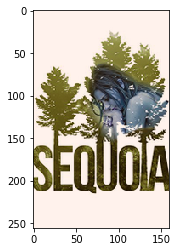

In [0]:
# A function to show movie posters
def show_image(movie_image): 
  img_pil = array_to_img(movie_image)
  plt.imshow(img_pil)
  
show_image(reshape_movies[31])

# (a) i. Dataset

### In orden to find the most frequent genres

In [0]:
scores_table = ListTable()
scores_table.append(np.append("Genre","Movies"))
for idx in biggest_genres_idxs:
  scores_table.append(np.append(original_genres_labels[idx],genres_sum[idx]))
  
scores_table

Genre,Movies
Drama,2681
Comedy,1337
Documentary,918
Horror,417
Western,173
Thriller,143


### Training and validation sets

In [0]:
# NOT NECESSARY AS THE NEXT CELL LOADS THE DATA
# Creating training and test sets
movies_genres = filtered_movies_genres
movies_images = np.array(reshape_movies)

training_fraction = 0.8
set_size = len(movies_genres)
movies_idxs = [i for i in range(set_size)]
random.shuffle(movies_idxs)
training_size = int(len(movies_idxs) * training_fraction)
movies_images_training = np.array([movies_images[m] for m in movies_idxs[0:training_size]])
movies_genres_training = np.array([movies_genres[m] for m in movies_idxs[0:training_size]])
movies_images_test = np.array([movies_images[m] for m in movies_idxs[training_size - 1:set_size]])
movies_genres_test = np.array([movies_genres[m] for m in movies_idxs[training_size - 1:set_size]])
print(f"Training set size (image): {len(movies_images_training)}")
print(f"Training set size (genre): {len(movies_genres_training)}")
print(f"Test set size (image): {len(movies_images_test)}")
print(f"Test set size (genre): {len(movies_genres_test)}")

Training set size (image): 4535
Training set size (genre): 4535
Test set size (image): 1135
Test set size (genre): 1135


In [0]:
# Reading training and test sets

filtered_dataset_path = 'drive/My Drive/ml-datasets/movies-training-validation.h5'
if not os.path.isfile(filtered_dataset_path) :
    hf = h5py.File(filtered_dataset_path, 'w')
    hf.create_dataset('images-train', data=movies_images_training)
    hf.create_dataset('genres-train', data=movies_genres_training)
    hf.create_dataset('images-test', data=movies_images_test)
    hf.create_dataset('genres-test', data=movies_genres_test)
    hf.close()
else :
    movies_filtered = h5py.File(filtered_dataset_path, 'r')
    print(list(movies_filtered.keys()))
    movies_images_training = movies_filtered['images-train']
    movies_genres_training = movies_filtered['genres-train']
    movies_images_test = movies_filtered['images-test']
    movies_genres_test = movies_filtered['genres-test']

['genres-test', 'genres-train', 'images-test', 'images-train']


In [0]:
print("Distribution training set")
table_content = []
table_content.append(["","Training set","Validation set"])

for idx, gidx in enumerate(biggest_genres_idxs):
  train_size = len([movie for movie in movies_genres_training if movie[gidx]==1])
  valid_size = len([movie for movie in movies_genres_test if movie[gidx]==1])
  table_content.append([original_genres_labels[gidx] ,train_size, valid_size])
  
scores_table = ListTable()
for line in table_content:
  scores_table.append(line)
  
scores_table


Distribution training set


,Training set,Validation set
Drama,2175,507
Comedy,1062,275
Documentary,717,201
Horror,332,85
Western,133,40
Thriller,116,27


# (a) ii. Direct prediction

In [0]:
# NOT NECESSARY AS THE NEXT LINE READ THE RESULTS
# Resizing the images to 224x224 square

import gc
square_movies_path="drive/My Drive/ml-datasets/squared-movies.npy"
if not os.path.isfile(square_movies_path):
  images_square = np.zeros((5669,224,224,3))

  for i in range(5669):
    if i%400==0:
      print(f"Garbage collector {i}")
      gc.collect()
    images_square[i]=resize(reshape_movies[i],(224,224), preserve_range=True)

  reshape_movies = 3
  gc.collect()

  np.save(square_movies_path, images_square)

In [0]:
# Read square images
square_movies_path="drive/My Drive/ml-datasets/squared-movies.npy"
images_square = np.load(square_movies_path)

In [0]:
# Instantiating the model
mobilenet_model = mobilenet.MobileNet(alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights='imagenet', input_tensor=None, pooling='avg')
mobilenet_model.summary()

W0706 02:44:52.139903 140659036948352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 02:44:52.187000 140659036948352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 02:44:52.208186 140659036948352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0706 02:44:52.248812 140659036948352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0706 02:44:52.249660 1406590369

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [0]:
# Predicting
movies_dp_labels = mobilenet_model.predict(images_square)

In [0]:
# Decoding predicted movies to MobileNet classes
dp_decoded_movies = decode_predictions(movies_dp_labels, top=2)

In [0]:
# Extracting indexes of most common classes
movies_labels = np.array([label[0][1] for label in dp_decoded_movies])
movies_labels_counter = Counter(movies_labels)
top_most_common = [label for (label, freq) in movies_labels_counter.most_common()[0:10]]
most_common_indexes = np.array([i for i, ml in enumerate(movies_labels) if ml in top_most_common])
print(f"Number of movies in the top 10 MobileNet classes: {len(most_common_indexes)}")

Number of movies in the top 10 MobileNet classes: 4111


In [0]:
# Confusstion Matrix
confusion_mat = np.zeros((len(biggest_genres_idxs), len(top_most_common)))
genres_idxs = list(biggest_genres_idxs)
for mi in most_common_indexes:
  genre_idx = list(filtered_movies_genres[mi]).index(1)
  genre_id = genres_idxs.index(genre_idx)
  mnc_idx = top_most_common.index(movies_labels[mi])
  confusion_mat[genre_id][mnc_idx]+=1

confusion_mat

array([[883., 350., 138., 135.,  83.,  65.,  59.,  58.,  71.,  65.],
       [400., 207., 101.,  64.,  88.,  25.,  56.,  49.,  28.,  21.],
       [278.,  92.,  34.,  54.,  33.,  33.,  23.,  14.,  26.,  24.],
       [ 89.,  61.,  33.,  20.,   8.,  45.,  10.,  13.,  17.,   9.],
       [ 45.,  40.,  14.,   6.,   5.,  13.,   5.,  13.,   2.,   1.],
       [ 39.,  25.,  11.,   8.,   3.,   5.,   2.,   4.,   4.,   4.]])

## Confusion matrix

In [0]:
genres_labels = np.array(original_genres_labels)[biggest_genres_idxs]
scores_table = ListTable()
scores_table.append(np.append("",top_most_common))
for idx, line in enumerate(confusion_mat):
  scores_table.append(np.append(genres_labels[idx],line))
  
scores_table

,envelope,jigsaw_puzzle,handkerchief,book_jacket,pillow,prayer_rug,tray,comic_book,quilt,toilet_tissue
Drama,883.0,350.0,138.0,135.0,83.0,65.0,59.0,58.0,71.0,65.0
Comedy,400.0,207.0,101.0,64.0,88.0,25.0,56.0,49.0,28.0,21.0
Documentary,278.0,92.0,34.0,54.0,33.0,33.0,23.0,14.0,26.0,24.0
Horror,89.0,61.0,33.0,20.0,8.0,45.0,10.0,13.0,17.0,9.0
Western,45.0,40.0,14.0,6.0,5.0,13.0,5.0,13.0,2.0,1.0
Thriller,39.0,25.0,11.0,8.0,3.0,5.0,2.0,4.0,4.0,4.0


#(c) Fine tuning

In [0]:
# Model parameters
img_width, img_height = 160, 256
nb_train_samples = len(movies_images_training)
nb_validation_samples = len(movies_images_test)
epochs = 50
batch_size = 16

In [0]:
# Resizing genres. Changes the Genres array from lenght 23 to 6
# movies_genres = np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres])
movies_genres_training=np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres_training])
movies_genres_test=np.array([movie_genre[biggest_genres_idxs] for movie_genre in movies_genres_test])
print(f"New shapes:\n Training: {movies_genres_training.shape}\n Test: {movies_genres_test.shape}")

New shapes:
 Training: (4535, 6)
 Test: (1135, 6)


In [0]:
print("Distribution training set")
for i in range(6):
  print(f"{i} : {len([movie for movie in movies_genres_training if movie[i]==1])}")

print("Distribution test set")
for i in range(6):
  print(f"{i} : {len([movie for movie in movies_genres_test if movie[i]==1])}")

Distribution training set
0 : 2175
1 : 1062
2 : 717
3 : 332
4 : 133
5 : 116
Distribution test set
0 : 507
1 : 275
2 : 201
3 : 85
4 : 40
5 : 27


In [0]:
# Training generator
datagen = ImageDataGenerator(rescale=1. / 255)
datagen.fit(movies_images_training)
generator = datagen.flow(movies_images_training, movies_genres_training, batch_size=32)

In [0]:
# Validation generator
vdatagen = ImageDataGenerator(rescale=1. / 255)
vdatagen.fit(movies_images_test)
vgenerator = vdatagen.flow(movies_images_test, movies_genres_test, batch_size=32)

In [0]:
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = applications.MobileNet(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(img_height, img_width, 3),
        pooling='avg')

for layer in base_model.layers:
        layer.trainable = True  # trainable has to be false in order to freeze the layers

op = Dense(256, activation='relu')(base_model.output)
op = Dropout(.25)(op)

output_tensor = Dense(6, activation='softmax')(op)
movies_model = Model(inputs=input_tensor, outputs=output_tensor)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
from sklearn.utils import class_weight
class_genres=[list(genre).index(1) for genre in movies_genres_training]
genres_weight = class_weight.compute_class_weight('balanced',np.unique(class_genres), class_genres)

In [0]:
# Training model
movies_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])
movies_features_train = movies_model.fit_generator(generator, steps_per_epoch=500, verbose=1, epochs=15, class_weight=genres_weight)

Epoch 1/15
500/500 [==============================] - 97s 194ms/step - loss: 0.0865 - categorical_accuracy: 0.9731
Epoch 2/15
500/500 [==============================] - 93s 186ms/step - loss: 0.0851 - categorical_accuracy: 0.9722
Epoch 3/15
500/500 [==============================] - 93s 185ms/step - loss: 0.0714 - categorical_accuracy: 0.9784
Epoch 4/15
500/500 [==============================] - 92s 185ms/step - loss: 0.0621 - categorical_accuracy: 0.9807
Epoch 5/15
500/500 [==============================] - 93s 185ms/step - loss: 0.0610 - categorical_accuracy: 0.9804
Epoch 6/15
500/500 [==============================] - 92s 185ms/step - loss: 0.0559 - categorical_accuracy: 0.9834
Epoch 7/15
500/500 [==============================] - 92s 184ms/step - loss: 0.0649 - categorical_accuracy: 0.9801
Epoch 8/15
500/500 [==============================] - 93s 185ms/step - loss: 0.0562 - categorical_accuracy: 0.9842
Epoch 9/15
500/500 [==============================] - 93s 185ms/step - loss: 0.0

In [0]:
movies_model.load_weights("drive/My Drive/ml-datasets/tranf-learning-model.h5")

In [0]:
movies_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 80, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 80, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 80, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 80, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 80, 32)       128       
__________

In [0]:
movies_labels_tl = movies_model.predict(movies_images_test)
movies_labels_tl.shape

(1135, 6)

In [0]:
len([movie for movie in movies_labels_tl if movie[5]>0.4])

10

In [0]:
# Confusstion Matrix
confusion_mat = np.zeros((len(biggest_genres_idxs), len(biggest_genres_idxs)))
genres_idxs= list(biggest_genres_idxs)
for idx, movie in enumerate(movies_genres_test):
  genre_idx = list(movie).index(1)
  genre_idx_tl = np.argmax(movies_labels_tl[idx])
  confusion_mat[genre_idx][genre_idx_tl]+=1

confusion_mat

array([[262., 118.,  72.,  47.,   2.,   6.],
       [ 62., 175.,  25.,  12.,   0.,   1.],
       [ 78.,  49.,  53.,  18.,   1.,   2.],
       [ 24.,  22.,  17.,  21.,   0.,   1.],
       [ 15.,  20.,   3.,   2.,   0.,   0.],
       [ 13.,   4.,   3.,   7.,   0.,   0.]])

In [0]:
genres_labels = np.array(original_genres_labels)[biggest_genres_idxs]
scores_table = ListTable()
table_titles = [f"{label} (pred)" for label in genres_labels]
scores_table.append(np.append("", table_titles))
for idx, freq in enumerate(confusion_mat):
  scores_table.append(np.append(genres_labels[idx], freq))
  
scores_table

,Drama (pred),Comedy (pred),Documentary (pred),Horror (pred),Western (pred),Thriller (pred)
Drama,262.0,118.0,72.0,47.0,2.0,6.0
Comedy,62.0,175.0,25.0,12.0,0.0,1.0
Documentary,78.0,49.0,53.0,18.0,1.0,2.0
Horror,24.0,22.0,17.0,21.0,0.0,1.0
Western,15.0,20.0,3.0,2.0,0.0,0.0
Thriller,13.0,4.0,3.0,7.0,0.0,0.0


In [0]:
expected = [ np.argmax(movie) for movie in movies_genres_test]
predicted = [ np.argmax(movie) for movie in  movies_labels_tl]
print("Classification report for classifier %s:\n%s\n"
      % (base_model, metrics.classification_report(expected, predicted)))

Classification report for classifier <keras.engine.training.Model object at 0x7f04bc4eaf60>:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55       507
           1       0.45      0.64      0.53       275
           2       0.31      0.26      0.28       201
           3       0.20      0.25      0.22        85
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        27

    accuracy                           0.45      1135
   macro avg       0.26      0.28      0.26      1135
weighted avg       0.44      0.45      0.44      1135




In [0]:
expected[801]

array([1, 0, 0, 0, 0, 0], dtype=int32)

# (b) Transfer learning

In [0]:
input_tensor = Input(shape=(img_height, img_width, 3))
base_model = applications.MobileNet(
        include_top=False,
        weights='imagenet',
        input_tensor=input_tensor,
        input_shape=(img_height, img_width, 3),
        pooling='avg')

for layer in base_model.layers:
        layer.trainable = False  # trainable has to be false in order to freeze the layers

op = Dense(256, activation='relu')(base_model.output)
op = Dropout(.25)(op)

output_tensor = Dense(6, activation='softmax')(op)
movies_tl_model = Model(inputs=input_tensor, outputs=output_tensor)

W0706 03:38:06.983863 139661556234112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 03:38:07.027173 139661556234112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0706 03:38:07.044890 139661556234112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.un

In [0]:
from sklearn.utils import class_weight
class_genres=[list(genre).index(1) for genre in movies_genres_training]
genres_weight = class_weight.compute_class_weight('balanced',np.unique(class_genres), class_genres)

In [0]:
# Training model
movies_tl_model.compile(optimizer=Adam(),loss='categorical_crossentropy',metrics=['categorical_accuracy'])
movies_features_train = movies_tl_model.fit_generator(generator, steps_per_epoch=500, verbose=1, epochs=15, class_weight=genres_weight)

W0706 03:39:04.670166 139661556234112 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0706 03:39:04.787681 139661556234112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/15
500/500 [==============================] - 22s 44ms/step - loss: 1.1163 - categorical_accuracy: 0.5746
Epoch 2/15
500/500 [==============================] - 17s 35ms/step - loss: 0.8784 - categorical_accuracy: 0.6580
Epoch 3/15
500/500 [==============================] - 17s 35ms/step - loss: 0.7220 - categorical_accuracy: 0.7240
Epoch 4/15
500/500 [==============================] - 17s 35ms/step - loss: 0.5738 - categorical_accuracy: 0.7842
Epoch 5/15
500/500 [==============================] - 18s 35ms/step - loss: 0.4317 - categorical_accuracy: 0.8401
Epoch 6/15
500/500 [==============================] - 18s 35ms/step - loss: 0.3436 - categorical_accuracy: 0.8762
Epoch 7/15
500/500 [==============================] - 18s 36ms/step - loss: 0.2708 - categorical_accuracy: 0.9001
Epoch 8/15
500/500 [==============================] - 18s 36ms/step - loss: 0.2293 - categorical_accuracy: 0.9193
Epoch 9/15
500/500 [==============================] - 18s 36ms/step - loss: 0.2033 - cat

In [0]:
movies_tl_model.save("drive/My Drive/ml-datasets/tranf-learning-model-train-false.h5")

In [0]:
movies_tl_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 160, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 257, 161, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 128, 80, 32)       864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 128, 80, 32)       128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 128, 80, 32)       0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 128, 80, 32)       288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 128, 80, 32)       128       
__________

In [0]:
movies_labels_tl = movies_tl_model.predict(movies_images_test)
movies_labels_tl.shape

(1135, 6)

In [0]:
len([movie for movie in movies_labels_tl if movie[5]>0.4])

0

In [0]:
# Confusstion Matrix
confusion_mat = np.zeros((len(biggest_genres_idxs), len(biggest_genres_idxs)))
genres_idxs= list(biggest_genres_idxs)
for idx, movie in enumerate(movies_genres_test):
  genre_idx = list(movie).index(1)
  genre_idx_tl = np.argmax(movies_labels_tl[idx])
  confusion_mat[genre_idx][genre_idx_tl]+=1

confusion_mat

array([[319.,  29., 128.,  31.,   0.,   0.],
       [156.,  43.,  55.,  21.,   0.,   0.],
       [102.,   8.,  80.,  11.,   0.,   0.],
       [ 41.,   5.,  27.,  12.,   0.,   0.],
       [ 26.,   8.,   3.,   3.,   0.,   0.],
       [ 15.,   4.,   5.,   3.,   0.,   0.]])

In [0]:
genres_labels = np.array(original_genres_labels)[biggest_genres_idxs]
scores_table = ListTable()
table_titles = [f"{label} (pred)" for label in genres_labels]
scores_table.append(np.append("", table_titles))
for idx, freq in enumerate(confusion_mat):
  scores_table.append(np.append(genres_labels[idx], freq))
  
scores_table

,Drama (pred),Comedy (pred),Documentary (pred),Horror (pred),Western (pred),Thriller (pred)
Drama,319.0,29.0,128.0,31.0,0.0,0.0
Comedy,156.0,43.0,55.0,21.0,0.0,0.0
Documentary,102.0,8.0,80.0,11.0,0.0,0.0
Horror,41.0,5.0,27.0,12.0,0.0,0.0
Western,26.0,8.0,3.0,3.0,0.0,0.0
Thriller,15.0,4.0,5.0,3.0,0.0,0.0


In [0]:
expected = [ np.argmax(movie) for movie in movies_genres_test]
predicted = [ np.argmax(movie) for movie in  movies_labels_tl]
print("Classification report for classifier %s:\n%s\n"
      % (base_model, metrics.classification_report(expected, predicted)))

Classification report for classifier <keras.engine.training.Model object at 0x7f04ce94f908>:
              precision    recall  f1-score   support

           0       0.48      0.63      0.55       507
           1       0.44      0.16      0.23       275
           2       0.27      0.40      0.32       201
           3       0.15      0.14      0.14        85
           4       0.00      0.00      0.00        40
           5       0.00      0.00      0.00        27

    accuracy                           0.40      1135
   macro avg       0.22      0.22      0.21      1135
weighted avg       0.38      0.40      0.37      1135




/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The precision, recall and f1-score are greather for the genres that have the largest number of poster movies in the data set, the first genre (Drama), have the best quality of prediction, as we expected. In the same way the three last genres have the worst prediction, because between the six genres they have a largest difference.

On the other hand, the performance with the fine tuning have an increase of approx 6/7% in the precision, recall and F1 for the first genre.